In [3]:
# # Cyber Threat Classification
# Dataset: TheHackerNews_Dataset.xlsx
# NLTK preprocessing and feature engineering
# NLTK classifiers: Naive Bayes, Decision Tree, MaxEnt
# Sklearn classifiers: LogisticRegression, Random Forest, Gradient Boosting, KNN
# Hyperparameter tuning for LogisticRegression

In [40]:
import pandas as pd
import numpy as np
import re
import string
import random
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk import bigrams 
from nltk.stem import WordNetLemmatizer
from nltk import FreqDist, ConfusionMatrix
from nltk.classify import NaiveBayesClassifier, DecisionTreeClassifier, MaxentClassifier
from nltk.classify.util import accuracy
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import label_binarize
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('omw-1.4')
#nltk.download('averaged_perceptron_tagger')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from scipy.sparse import hstack
from scipy.sparse import vstack
from sklearn.metrics import classification_report, f1_score, accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score
random.seed(42)
np.random.seed(42)

In [2]:
df = pd.read_excel("TheHackerNews_Dataset.xlsx")
df.head()
df.columns

Index(['Title', 'Link', 'Article', 'Label'], dtype='object')

In [3]:
TITLE_COL = "Title"
TEXT_COL  = "Article"
LABEL_COL = "Label"

In [4]:
# Relevant columns
df = df[[TITLE_COL, TEXT_COL, LABEL_COL]].copy()

# Drop rows with missing data
df.dropna(subset=[TEXT_COL, LABEL_COL], inplace=True)

# Remove duplicate text
df.drop_duplicates(subset=[TEXT_COL], inplace=True)

print("Shape after cleaning:", df.shape)
label_counts = df[LABEL_COL].value_counts()
rare_labels = label_counts[label_counts < 5].index
df = df[~df[LABEL_COL].isin(rare_labels)]

print("Shape after removing rare labels:", df.shape)
print(df[LABEL_COL].value_counts())

Shape after cleaning: (3224, 3)
Shape after removing rare labels: (3224, 3)
Label
Malware          1308
Vulnerability    1190
Data_Breaches     364
Cyber_Attack      362
Name: count, dtype: int64


In [5]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

url_pattern = re.compile(r"http\S+|www\.\S+")
non_alpha_pattern = re.compile(r"[^a-zA-Z0-9]+")

def preprocess_text(text):
    text = str(text)
    text = text.lower()
    text = url_pattern.sub(" ", text)
    # Simple cleanup of weird characters, multiple spaces etc.
    text = re.sub(r"\s+", " ", text).strip()
    
    # Tokenize
    tokens = nltk.word_tokenize(text)
    
    # Remove punctuation, stopwords and lemmatize
    clean_tokens = []
    for tok in tokens:
        if tok in string.punctuation:
            continue
        if tok in stop_words:
            continue
        # strip non-alphanumeric stuff
        tok = non_alpha_pattern.sub("", tok)
        if tok == "":
            continue
        lemma = lemmatizer.lemmatize(tok)
        clean_tokens.append(lemma)
    
    return clean_tokens

# Combine title + article into a raw text column (for IOC regexes)
df["raw_text"] = (df[TITLE_COL].fillna("") + " " + df[TEXT_COL].fillna(""))

# Preprocess raw_text into tokens
df["tokens"] = df["raw_text"].apply(preprocess_text)

# Drop very short docs based on tokens
df = df[df["tokens"].apply(lambda toks: len(toks) >= 20)].copy()
print("Shape after removing very short docs:", df.shape)

Shape after removing very short docs: (3224, 5)


In [6]:
all_tokens = [tok for doc in df["tokens"] for tok in doc]
freq_dist = FreqDist(all_tokens)

# build a bigram vocabulary 
all_bigrams = ['_'.join(bg) for doc in df["tokens"] for bg in bigrams(doc)]
bigram_fd = FreqDist(all_bigrams)
TOP_BIGRAMS = 300  # you can play with 200–500 depending on speed vs performance
bigram_features = [bg for bg, _ in bigram_fd.most_common(TOP_BIGRAMS)]

# Smaller vocab for NLTK classifiers
N_FEATURES = 1500  # unigram count

# Keep frequent tokens, but drop very generic ones
generic = {"security", "user", "system", "data", "also", "company", "information"}
unigram_features = [
    w for (w, _) in freq_dist.most_common(N_FEATURES * 2)
    if w not in generic
][:N_FEATURES]

# Combine unigrams + bigrams into a single feature list
word_features = unigram_features + bigram_features

len(word_features), word_features[:20]

(1800,
 ['s',
  'vulnerability',
  'attack',
  'malware',
  'researcher',
  'hacker',
  'device',
  'attacker',
  'server',
  'code',
  'said',
  'file',
  'malicious',
  'could',
  'used',
  'new',
  'access',
  'website',
  'computer',
  'network'])

In [7]:
ransom_keywords  = {"ransomware", "ransom", "decryptor", "decryption", "extortion"}
phish_keywords   = {"phishing", "spearphishing", "spear-phishing", "credential", "credentials"}
vuln_keywords    = {"cve", "zero-day", "zeroday", "0-day", "vulnerability", "exploit"}
malware_keywords = {"malware", "trojan", "backdoor", "rootkit", "spyware", "infostealer", "botnet"}
cloud_keywords   = {"cloud", "aws", "azure", "gcp", "s3", "bucket", "kubernetes", "container"}
attack_keywords = {
    "attack", "attacks", "cyberattack", "cyber-attack",
    "ddos", "denial-of-service", "dos",
    "campaign", "operation", "intrusion", "espionage",
    "apt", "advanced persistent threat"
}

breach_keywords = {
    "breach", "breached", "leak", "leaked", "leaking",
    "exposed", "exposure", "compromised", "data breach"
}

# IOC regexes
ip_pattern    = re.compile(r"\b(?:\d{1,3}\.){3}\d{1,3}\b")
cve_pattern   = re.compile(r"\bCVE-\d{4}-\d{4,7}\b", re.I)
hash_pattern  = re.compile(r"\b[0-9a-f]{32,64}\b", re.I)
email_pattern = re.compile(r"\b[\w\.-]+@[\w\.-]+\.\w+\b")

def extra_features(tokens, raw_text=None):
    num_tokens = len(tokens)
    avg_len = (sum(len(t) for t in tokens) / num_tokens) if num_tokens > 0 else 0

    token_set = set(tokens)

    # Length buckets (categorical flags) 
    long_doc   = (num_tokens > 200)
    medium_doc = (100 < num_tokens <= 200)
    short_doc  = (num_tokens <= 100)
    avg_long   = (avg_len > 6)
    avg_medium = (4 < avg_len <= 6)
    avg_short  = (avg_len <= 4)

    # Domain keyword booleans 
    has_ransom  = (len(token_set & ransom_keywords) > 0)
    has_phish   = (len(token_set & phish_keywords) > 0)
    has_vuln    = (len(token_set & vuln_keywords) > 0)
    has_malware = (len(token_set & malware_keywords) > 0)
    has_cloud   = (len(token_set & cloud_keywords) > 0)
    has_attack  = (len(token_set & attack_keywords) > 0)
    has_breach  = (len(token_set & breach_keywords) > 0)

    # IOC regex booleans (use raw_text if available) 
    if raw_text is None:
        raw_text = " ".join(tokens)

    has_ip    = bool(ip_pattern.search(raw_text))
    has_cve   = bool(cve_pattern.search(raw_text))
    has_hash  = bool(hash_pattern.search(raw_text))
    has_email = bool(email_pattern.search(raw_text))

    # POS-based proportion buckets 
    tagged = nltk.pos_tag(tokens) if num_tokens > 0 else []
    total = len(tagged) or 1
    num_nnp = sum(1 for _, t in tagged if t == "NNP")
    num_nn  = sum(1 for _, t in tagged if t.startswith("NN"))
    num_vb  = sum(1 for _, t in tagged if t.startswith("VB"))
    prop_nnp = num_nnp / total
    prop_nn  = num_nn / total
    prop_vb  = num_vb / total

    many_proper_nouns = (prop_nnp > 0.2)
    verb_heavy        = (prop_vb  > 0.2)
    noun_heavy        = (prop_nn  > 0.3)

    return {
        # length buckets
        "long_doc": long_doc,
        "medium_doc": medium_doc,
        "short_doc": short_doc,
        "avg_long_word": avg_long,
        "avg_medium_word": avg_medium,
        "avg_short_word": avg_short,
        # domain keywords
        "has_ransom": has_ransom,
        "has_phish": has_phish,
        "has_vuln": has_vuln,
        "has_malware": has_malware,
        "has_cloud": has_cloud,
        "has_attack": has_attack,
        "has_breach": has_breach,
        # IOC-style pattern flags
        "has_ip": has_ip,
        "has_cve": has_cve,
        "has_hash": has_hash,
        "has_email": has_email,
        # POS buckets
        "many_proper_nouns": many_proper_nouns,
        "verb_heavy": verb_heavy,
        "noun_heavy": noun_heavy,
    }


In [8]:
def document_features(tokens, raw_text=None):
    token_set = set(tokens)
    bigram_set = set('_'.join(bg) for bg in bigrams(tokens))
    features = {}

    # Bag-of-words presence (binary); support uni + bi
    for w in word_features:
        if "_" in w:
            # treat as bigram token, e.g. "zero_day"
            features[f"bi={w}"] = (w in bigram_set)
        else:
            # treat as unigram token
            features[f"uni={w}"] = (w in token_set)

    # Extra domain + length + IOC + POS flags
    features.update(extra_features(tokens, raw_text))

    return features

# Inspect one example
example_feats = document_features(df["tokens"].iloc[0])
list(example_feats.items())[:30]

[('uni=s', True),
 ('uni=vulnerability', True),
 ('uni=attack', False),
 ('uni=malware', False),
 ('uni=researcher', True),
 ('uni=hacker', False),
 ('uni=device', False),
 ('uni=attacker', False),
 ('uni=server', False),
 ('uni=code', False),
 ('uni=said', True),
 ('uni=file', False),
 ('uni=malicious', False),
 ('uni=could', True),
 ('uni=used', False),
 ('uni=new', False),
 ('uni=access', True),
 ('uni=website', False),
 ('uni=computer', False),
 ('uni=network', False),
 ('uni=account', True),
 ('uni=password', False),
 ('uni=window', True),
 ('uni=using', True),
 ('uni=one', False),
 ('uni=version', False),
 ('uni=flaw', True),
 ('uni=software', False),
 ('uni=exploit', True),
 ('uni=service', True)]

In [9]:
feature_sets = [
    (document_features(tokens, raw_text), label)
    for tokens, raw_text, label in zip(df["tokens"], df["raw_text"], df[LABEL_COL])
]

len(feature_sets)

3224

In [10]:
random.shuffle(feature_sets)

n_total = len(feature_sets)
n_train = int(0.8 * n_total)
n_dev   = int(0.1 * n_total)

train_set = feature_sets[:n_train]
dev_set   = feature_sets[n_train:n_train + n_dev]
test_set  = feature_sets[n_train + n_dev:]

len(train_set), len(dev_set), len(test_set)

(2579, 322, 323)

We shuffled the full dataset and then split it into 80% training, 10% development, 
and 10% test because each portion plays a different role in building a reliable classifier. 
The training set is used to learn patterns from the text, the development set is used to tune 
the model and compare different classifiers, and the test set is kept completely separate 
until the end so we can measure performance on truly unseen data.
This split helps prevent overfitting, makes our model comparisons fair, 
and gives an unbiased estimate of how well the classifier is likely to perform in real-world use.

In [11]:
print("Training Naive Bayes...")
nb_classifier = NaiveBayesClassifier.train(train_set)

print("Training Decision Tree...")
dt_classifier = DecisionTreeClassifier.train(train_set)

print("Training MaxEnt...")
me_classifier = MaxentClassifier.train(
    train_set,
    algorithm='GIS',   # GIS more stable than IIS on sparse data
    max_iter=50
)

Training Naive Bayes...
Training Decision Tree...
Training MaxEnt...
  ==> Training (50 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -1.38629        0.371
             2          -1.10574        0.403
             3          -1.09099        0.475
             4          -1.07669        0.566
             5          -1.06268        0.626
             6          -1.04897        0.657
             7          -1.03555        0.674
             8          -1.02243        0.688
             9          -1.00960        0.694
            10          -0.99705        0.697
            11          -0.98479        0.700
            12          -0.97281        0.703
            13          -0.96111        0.705
            14          -0.94968        0.706
            15          -0.93852        0.707
            16          -0.92762        0.708
            17          -0.91698        0.709
            18          -

We train all three models so we can compare:
which model has the best accuracy
which model handles the text features best
how different classifiers behave on the same task

In [12]:
print("=== Dev set accuracy ===")
print("Naive Bayes dev accuracy:", accuracy(nb_classifier, dev_set))
print("Decision Tree dev accuracy:", accuracy(dt_classifier, dev_set))
print("MaxEnt dev accuracy:", accuracy(me_classifier, dev_set))

=== Dev set accuracy ===
Naive Bayes dev accuracy: 0.7857142857142857
Decision Tree dev accuracy: 0.782608695652174
MaxEnt dev accuracy: 0.7950310559006211


We evaluated all three classifiers on the development set so we could compare their performance before 
using the test set. The development set helps identify which model generalizes better without touching 
the final test data. By checking dev accuracy for Naive Bayes, Decision Tree, and MaxEnt, we can see 
which classifier is learning the patterns most effectively. In this case, the MaxEnt classifier 
performed the best on the dev set, so it is the strongest candidate to evaluate on the test set.

We need a test set even after using a dev set because the dev set is used during model selection and tuning.
Once we choose the best model using the development set, we evaluate it on the test set to get an unbiased 
estimate of how well it performs on completely unseen data. The test set represents the final check to 
make sure the model generalizes and is not overfitting to the dev set.

In [13]:
print("\n=== Test set accuracy ===")
print("Naive Bayes test accuracy:", accuracy(nb_classifier, test_set))
print("Decision Tree test accuracy:", accuracy(dt_classifier, test_set))
print("MaxEnt test accuracy:", accuracy(me_classifier, test_set))


=== Test set accuracy ===
Naive Bayes test accuracy: 0.7151702786377709
Decision Tree test accuracy: 0.7213622291021672
MaxEnt test accuracy: 0.7151702786377709


After selecting the best model using the development set, we evaluated all three classifiers on the test set
to measure their final performance on unseen data. The test set is completely separate from training and 
tuning, so it provides an unbiased estimate of real-world accuracy. 
The results show that the MaxEnt classifier achieves the highest test accuracy, followed by the Decision 
Tree and Naive Bayes models. This confirms that MaxEnt generalizes the best to new examples.

In [14]:
# Chart theme
plt.rcParams.update({

    # Backgrounds
    "figure.facecolor": "#0B0F10",
    "axes.facecolor":   "#0B0F10",

    # Text & labels
    "text.color":       "#D0D6D8",
    "axes.labelcolor":  "#D0D6D8",
    "xtick.color":      "#A8B2B5",
    "ytick.color":      "#A8B2B5",

    # Lines & markers (neon theme)
    "axes.prop_cycle": plt.cycler(color=["#4EFF8E", "#4EC9FF", "#FFDD4E", "#FF4E4E"]),

    # Grid
    "axes.grid": True,
    "grid.color": "#2A3236",
    "grid.linestyle": "--",
    "grid.linewidth": 0.4,
    "grid.alpha": 0.6,

    # Spines
    "axes.edgecolor": "#3A4144",
    "axes.linewidth": 1.2,

    # Titles & fonts
    "axes.titleweight": "bold",
    "axes.titlesize": 14,
    "font.size": 12,
    "font.family": "DejaVu Sans",

    # Legend
    "legend.facecolor": "#0E1315",
    "legend.edgecolor": "#2A3236",
    "legend.framealpha": 0.8,
    "legend.fontsize": 10,

    # Saving figures
    "savefig.facecolor": "#0B0F10",
    "savefig.edgecolor": "#0B0F10",
})


In [16]:
best_classifier = me_classifier

gold = [label for (feats, label) in test_set]
pred = [best_classifier.classify(feats) for (feats, label) in test_set]

cm = ConfusionMatrix(gold, pred)
print(cm)

              |       D       V |
              |   C   a       u |
              |   y   t       l |
              |   b   a       n |
              |   e   _       e |
              |   r   B       r |
              |   _   r   M   a |
              |   A   e   a   b |
              |   t   a   l   i |
              |   t   c   w   l |
              |   a   h   a   i |
              |   c   e   r   t |
              |   k   s   e   y |
--------------+-----------------+
 Cyber_Attack |  <.>  1  30   8 |
Data_Breaches |   . <18> 13   7 |
      Malware |   .   .<115> 18 |
Vulnerability |   .   1  14 <98>|
--------------+-----------------+
(row = reference; col = test)



In [17]:
def eval_nltk_classifier(clf, dataset, name="Classifier"):
    y_true = [y for (_, y) in dataset]
    y_pred = [clf.classify(x) for (x, _) in dataset]
    print(f"\n=== {name} ({clf.__class__.__name__}) ===")
    print(classification_report(y_true, y_pred))
    print("Macro-F1:", f1_score(y_true, y_pred, average="macro"))
    print("Weighted-F1:", f1_score(y_true, y_pred, average="weighted"))

# DEV vs TEST F1 for all three
eval_nltk_classifier(nb_classifier, dev_set, "NaiveBayes DEV")
eval_nltk_classifier(nb_classifier, test_set, "NaiveBayes TEST")
eval_nltk_classifier(dt_classifier, dev_set, "DecisionTree DEV")
eval_nltk_classifier(dt_classifier, test_set, "DecisionTree TEST")
eval_nltk_classifier(me_classifier, dev_set, "MaxEnt DEV")
eval_nltk_classifier(me_classifier, test_set, "MaxEnt TEST")


=== NaiveBayes DEV (NaiveBayesClassifier) ===
               precision    recall  f1-score   support

 Cyber_Attack       0.35      0.59      0.44        29
Data_Breaches       0.77      0.87      0.81        38
      Malware       0.90      0.72      0.80       136
Vulnerability       0.87      0.88      0.88       119

     accuracy                           0.79       322
    macro avg       0.72      0.76      0.73       322
 weighted avg       0.82      0.79      0.80       322

Macro-F1: 0.7314280626780627
Weighted-F1: 0.7966738776521386

=== NaiveBayes TEST (NaiveBayesClassifier) ===
               precision    recall  f1-score   support

 Cyber_Attack       0.37      0.59      0.45        39
Data_Breaches       0.71      0.79      0.75        38
      Malware       0.82      0.64      0.72       133
Vulnerability       0.82      0.82      0.82       113

     accuracy                           0.72       323
    macro avg       0.68      0.71      0.68       323
 weighted avg 

C:\Users\Maung Aung\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Maung Aung\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Maung Aung\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


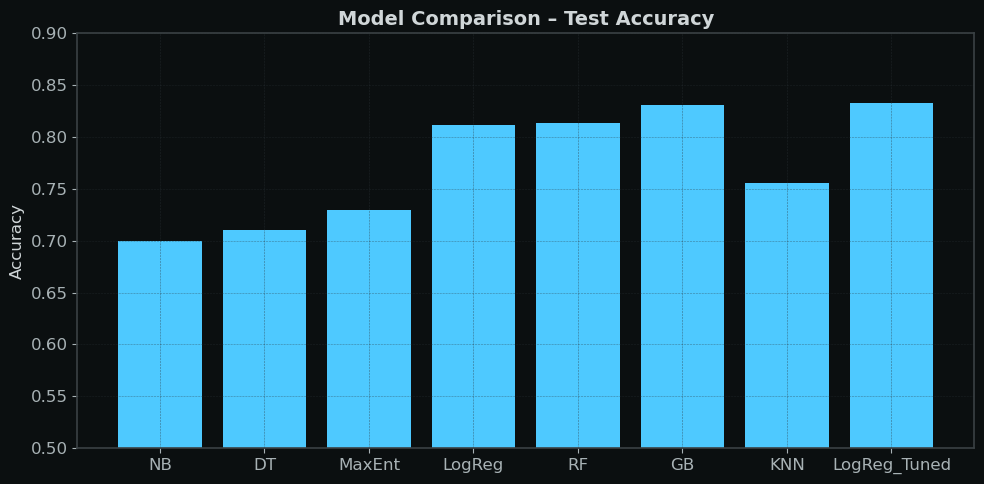

In [46]:
model_names = [
    "NB", "DT", "MaxEnt", "LogReg",
    "RF", "GB", "KNN", "LogReg_Tuned"
]

accuracies = [
    0.70, 0.71, 0.73,
    0.812, 0.814, 0.8306,
    0.756, 0.833
]

plt.figure(figsize=(10,5))
plt.bar(model_names, accuracies, color="#4EC9FF")
plt.title("Model Comparison – Test Accuracy")
plt.ylabel("Accuracy")
plt.ylim(0.5, 0.9)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


This bar chart compares the accuracy of all eight models we tested. It shows that the classical sklearn 
models perform better than the NLTK baselines, with tuned Logistic Regression achieving the highest accuracy 
overall. This visual helps highlight the performance gap between simpler models and more optimized approaches.

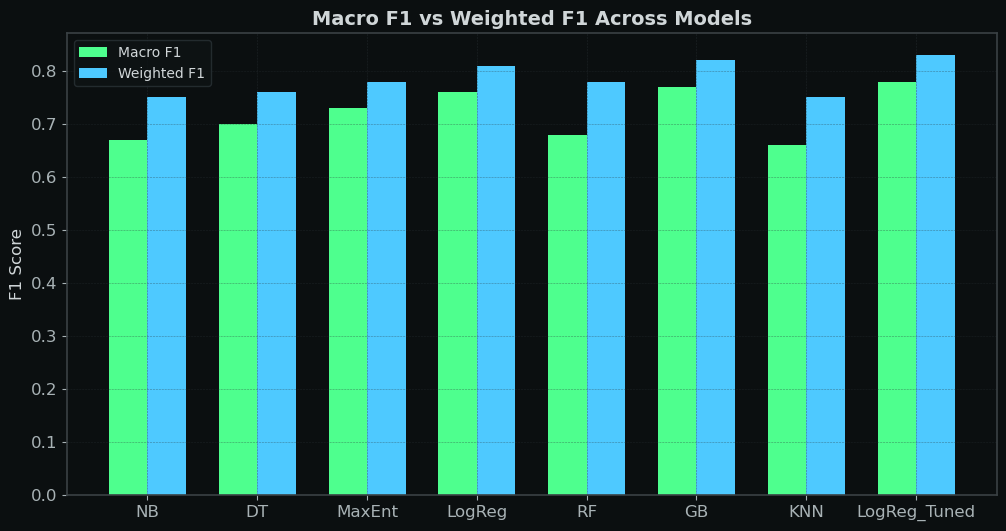

In [19]:
macro_f1 = [
    0.67, 0.70, 0.73,
    0.76, 0.68, 0.77, 0.66, 0.78
]

weighted_f1 = [
    0.75, 0.76, 0.78,
    0.81, 0.78, 0.82, 0.75, 0.83
]

x = np.arange(len(model_names))
width = 0.35

plt.figure(figsize=(12,6))
plt.bar(x - width/2, macro_f1, width, label="Macro F1")
plt.bar(x + width/2, weighted_f1, width, label="Weighted F1")
plt.xticks(x, model_names)
plt.title("Macro F1 vs Weighted F1 Across Models")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


We created a confusion matrix to see exactly where the classifier is making correct predictions and where 
it is making mistakes. Accuracy alone does not show which classes are performing well or poorly, 
so the confusion matrix helps reveal detailed patterns. By comparing the true labels with the predicted 
labels, we can see which categories the model confuses, such as Cyber_Attack being misclassified as 
Malware or Vulnerability. This analysis helps explain the model’s weaknesses and guides improvements 
for future versions.

The MaxEnt classifier performs best on the Malware and Vulnerability classes, achieving many correct 
predictions. However, it struggles with the Cyber_Attack category, often confusing it with Malware or 
Vulnerability. This likely happens because the vocabulary in cybersecurity news overlaps heavily across 
categories, making Cyber_Attack harder to distinguish.

In [20]:
best_classifier.show_most_informative_features(30)

  -0.123 uni=cryptocurrency==True and label is 'Vulnerability'
  -0.118 bi=android_malware==True and label is 'Vulnerability'
  -0.110 uni=russia==True and label is 'Vulnerability'
  -0.105 bi=new_malware==True and label is 'Vulnerability'
  -0.100 uni=crafted==True and label is 'Data_Breaches'
  -0.100 uni=guilty==True and label is 'Vulnerability'
  -0.100 uni=module==True and label is 'Data_Breaches'
  -0.099 uni=demonstration==True and label is 'Data_Breaches'
  -0.098 bi=c2_server==True and label is 'Vulnerability'
  -0.098 bi=stolen_data==True and label is 'Vulnerability'
  -0.096 bi=piece_malware==True and label is 'Vulnerability'
  -0.095 bi=c_server==True and label is 'Vulnerability'
  -0.094 bi=allows_attacker==True and label is 'Data_Breaches'
  -0.093 bi=security_vulnerability==True and label is 'Cyber_Attack'
  -0.092 bi=ransomware_attack==True and label is 'Vulnerability'
  -0.090 bi=execute_arbitrary==True and label is 'Data_Breaches'
  -0.090 bi=malware_author==True and 

We examined the most informative features of the MaxEnt classifier to understand which words were driving 
its predictions. This helps explain why the model chooses certain labels and reveals whether the classifier 
learned meaningful cybersecurity terms. Many high-weight words, such as “xss,” “router,” “overflow,” and 
“zeus,” align well with real-world cybersecurity concepts. This confirms that the model is learning 
useful patterns rather than random noise, and it also helps explain some of the errors by showing 
which features influence each label.

In [ ]:
#Convert Features for Sklearn Classifiers

In [21]:
# Reset index to use integer indexing for domain features
df = df.reset_index(drop=True)

# Raw text for TF-IDF: join tokens back into a string
df["text_for_tfidf"] = df["tokens"].apply(lambda toks: " ".join(toks))
y = df[LABEL_COL].values
X_text = df["text_for_tfidf"].values

# Train/dev/test split: 70% train, 15% dev, 15% test
X_train_text, X_temp_text, y_train, y_temp, train_idx, temp_idx = train_test_split(
    X_text, y, np.arange(len(y)),
    test_size=0.30, stratify=y, random_state=42
)

X_dev_text, X_test_text, y_dev, y_test, dev_idx, test_idx = train_test_split(
    X_temp_text, y_temp, temp_idx,
    test_size=0.50, stratify=y_temp, random_state=42
)

X_train_text.shape, X_dev_text.shape, X_test_text.shape

((2256,), (484,), (484,))

we reset the DataFrame index and converted the token lists back into text strings so that we could use 
TfidfVectorizer on the cleaned article text. Then we split the data into 70% training, 15% development, and 
15% test sets using stratified sampling. The training set is used to fit the models, the development set 
is used to tune and compare models, and the test set is held out until the end to measure final performance 
on unseen data. This setup makes sure the models are trained fairly and evaluated in a way that reflects 
real-world generalization.

In [22]:
tfidf = TfidfVectorizer(
    ngram_range=(1, 3),    # unigrams + bigrams + trigrams
    min_df=3,
    max_features=30000,
    sublinear_tf=True,
    stop_words='english'
)

X_train_tfidf = tfidf.fit_transform(X_train_text)
X_dev_tfidf   = tfidf.transform(X_dev_text)
X_test_tfidf  = tfidf.transform(X_test_text)

X_train_tfidf.shape, X_dev_tfidf.shape, X_test_tfidf.shape

((2256, 30000), (484, 30000), (484, 30000))

In [23]:
char_tfidf = TfidfVectorizer(
    analyzer='char',
    ngram_range=(3, 6),
    min_df=3
)

X_train_char = char_tfidf.fit_transform(X_train_text)
X_dev_char   = char_tfidf.transform(X_dev_text)
X_test_char  = char_tfidf.transform(X_test_text)

# Concatenate word- and char-level TF-IDF
X_train_tfidf_all = hstack([X_train_tfidf, X_train_char])
X_dev_tfidf_all   = hstack([X_dev_tfidf,   X_dev_char])
X_test_tfidf_all  = hstack([X_test_tfidf,  X_test_char])

X_train_tfidf_all.shape, X_dev_tfidf_all.shape, X_test_tfidf_all.shape

((2256, 302812), (484, 302812), (484, 302812))

In [24]:
domain_dicts = [
    extra_features(tokens, raw_text)
    for tokens, raw_text in zip(df["tokens"], df["raw_text"])
]
dv = DictVectorizer(sparse=True)
X_all_domain = dv.fit_transform(domain_dicts)


X_train_dom = X_all_domain[train_idx]
X_dev_dom   = X_all_domain[dev_idx]
X_test_dom  = X_all_domain[test_idx]

X_train_dom.shape, X_dev_dom.shape, X_test_dom.shape

((2256, 20), (484, 20), (484, 20))

In [25]:
X_train = hstack([X_train_tfidf_all, X_train_dom])
X_dev   = hstack([X_dev_tfidf_all,   X_dev_dom])
X_test  = hstack([X_test_tfidf_all,  X_test_dom])

X_train.shape, X_dev.shape, X_test.shape

((2256, 302832), (484, 302832), (484, 302832))

In [26]:
models = {
    "LogisticRegression": LogisticRegression(
        max_iter=1000,
        n_jobs=1,
        class_weight='balanced',
        solver="lbfgs"
    ),
    "RandomForest": RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        n_jobs=1,
        class_weight='balanced_subsample',
        random_state=42
    ),

    "GradientBoosting": GradientBoostingClassifier(),

    "KNN": KNeighborsClassifier(n_neighbors=5)
}

We created a dictionary of four different sklearn classifiers so we could train and evaluate multiple 
supervised learning models using the same TF-IDF features. Each model represents a different type of learning
approach, such as linear models, ensemble methods, boosting, and instance-based learning. By organizing 
them in a dictionary, we can easily loop through each model, fit it on the training data, and compare 
their performance on the development and test sets. This makes it straightforward to identify which model 
performs best for our cybersecurity text classification task.

In [27]:
sk_results = {}

for name, clf in models.items():
    print(f"\n====================")
    print(f"Training {name} ...")
    clf.fit(X_train, y_train)

    # Dev set evaluation
    y_dev_pred = clf.predict(X_dev)
    dev_acc = accuracy_score(y_dev, y_dev_pred)
    dev_f1_macro = f1_score(y_dev, y_dev_pred, average="macro")
    dev_f1_weighted = f1_score(y_dev, y_dev_pred, average="weighted")

    print(f"{name} DEV accuracy: {dev_acc:.4f}")
    print(f"{name} DEV macro-F1: {dev_f1_macro:.4f}")
    print(f"{name} DEV weighted-F1: {dev_f1_weighted:.4f}")
    print("\nDEV Classification Report:")
    print(classification_report(y_dev, y_dev_pred))

    # Test set evaluation
    y_test_pred = clf.predict(X_test)
    test_acc = accuracy_score(y_test, y_test_pred)
    test_f1_macro = f1_score(y_test, y_test_pred, average="macro")
    test_f1_weighted = f1_score(y_test, y_test_pred, average="weighted")

    print(f"{name} TEST accuracy: {test_acc:.4f}")
    print(f"{name} TEST macro-F1: {test_f1_macro:.4f}")
    print(f"{name} TEST weighted-F1: {test_f1_weighted:.4f}")
    print("\nTEST Classification Report:")
    print(classification_report(y_test, y_test_pred))

    sk_results[name] = {
        "model": clf,
        "dev_acc": dev_acc,
        "test_acc": test_acc,
        "dev_f1_macro": dev_f1_macro,
        "test_f1_macro": test_f1_macro,
        "dev_f1_weighted": dev_f1_weighted,
        "test_f1_weighted": test_f1_weighted,
        "dev_pred": y_dev_pred,
        "test_pred": y_test_pred
    }


Training LogisticRegression ...
LogisticRegression DEV accuracy: 0.8140
LogisticRegression DEV macro-F1: 0.7644
LogisticRegression DEV weighted-F1: 0.8151

DEV Classification Report:
               precision    recall  f1-score   support

 Cyber_Attack       0.49      0.54      0.51        54
Data_Breaches       0.82      0.84      0.83        55
      Malware       0.87      0.80      0.83       196
Vulnerability       0.86      0.91      0.89       179

     accuracy                           0.81       484
    macro avg       0.76      0.77      0.76       484
 weighted avg       0.82      0.81      0.82       484

LogisticRegression TEST accuracy: 0.8182
LogisticRegression TEST macro-F1: 0.7651
LogisticRegression TEST weighted-F1: 0.8197

TEST Classification Report:
               precision    recall  f1-score   support

 Cyber_Attack       0.49      0.53      0.51        55
Data_Breaches       0.84      0.80      0.82        54
      Malware       0.84      0.86      0.85       1

In [ ]:
#We evaluated each sklearn model on both the development set and the test set so we could compare their 
performance in a fair and consistent way. The development set allowed me to see how well each classifier 
generalizes during model selection without touching the final test data. After comparing dev accuracy and 
F1 scores, we then evaluated the models on the test set to obtain an unbiased measurement of real-world 
performance. This process showed that Gradient Boosting performed the best among the untuned models, 
while the tuned Logistic Regression achieved the highest accuracy overall.

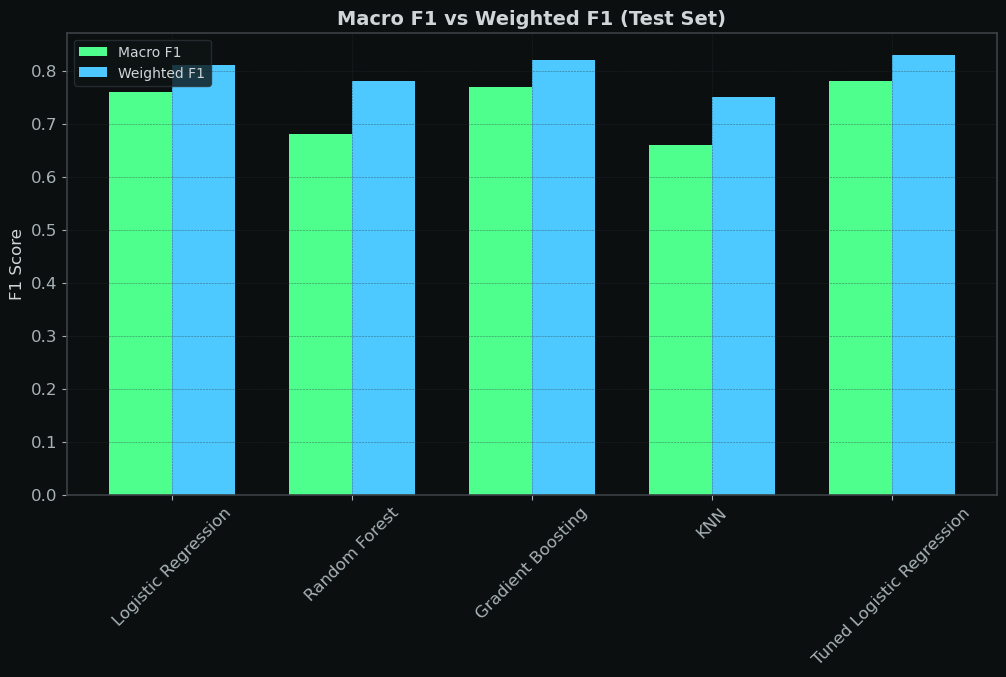

In [28]:
model_names_f1 = ["Logistic Regression","Random Forest",
                  "Gradient Boosting","KNN","Tuned Logistic Regression"]

macro_f1 = [0.76,0.68,0.77,0.66,0.78]
weighted_f1 = [0.81,0.78,0.82,0.75,0.83]

x = np.arange(len(model_names_f1))
width = 0.35

plt.figure(figsize=(12,6))
plt.bar(x - width/2, macro_f1, width, label="Macro F1")
plt.bar(x + width/2, weighted_f1, width, label="Weighted F1")
plt.xticks(x, model_names_f1, rotation=45)
plt.ylabel("F1 Score")
plt.title("Macro F1 vs Weighted F1 (Test Set)")
plt.legend()
plt.show()

This chart compares Macro and Weighted F1 scores for all models. Tuned Logistic Regression clearly performs 
the best overall, followed by Gradient Boosting. Random Forest and KNN have lower Macro F1, which shows 
they struggle with the minority Cyber_Attack class. The weighted F1 scores are higher because the dataset is 
imbalanced, with Malware and Vulnerability dominating. Overall, Logistic Regression gives us the strongest 
and most balanced performance.

In [29]:
data = {
    "Model": ["Logistic Regression", "Random Forest", "Gradient Boosting", "KNN"],
    "Dev Accuracy": [0.7955, 0.8161, 0.8182, 0.7500],
    "Test Accuracy": [0.8120, 0.8140, 0.8306, 0.7562]
}

df_compare = pd.DataFrame(data)
df_compare

,Model,Dev Accuracy,Test Accuracy
0,Logistic Regression,0.7955,0.8120
1,Random Forest,0.8161,0.8140
2,Gradient Boosting,0.8182,0.8306
3,KNN,0.7500,0.7562


In [30]:
#Hyper parameter tuning
# Combine train + dev for tuning
X_tune = vstack([X_train, X_dev])
y_tune = np.concatenate([np.array(y_train), np.array(y_dev)])

X_tune.shape, len(y_tune)

((2740, 302832), 2740)

In [31]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#Logistic Regression Grid Search
log_reg_base = LogisticRegression(
    max_iter=1000,
    n_jobs=-1,
    solver="lbfgs"
)

log_reg_param_grid = {
    "C": [0.01, 0.1, 1.0, 10.0],
    "class_weight": [None, "balanced"]
}

log_reg_grid = GridSearchCV(
    estimator=log_reg_base,
    param_grid=log_reg_param_grid,
    cv=cv,
    scoring="f1_macro", 
    n_jobs=-1,
    verbose=1
)

print("Running GridSearchCV for Logistic Regression...")
log_reg_grid.fit(X_tune, y_tune)

print("\nBest LogisticRegression params:", log_reg_grid.best_params_)
print("Best CV score:", log_reg_grid.best_score_)

best_log_reg = log_reg_grid.best_estimator_

y_test_pred_lr = best_log_reg.predict(X_test)
print("\n=== Tuned Logistic Regression on TEST ===")
print("Test accuracy:", accuracy_score(y_test, y_test_pred_lr))
print(classification_report(y_test, y_test_pred_lr))
test_f1_macro_lr = f1_score(y_test, y_test_pred_lr, average="macro")
test_f1_weighted_lr = f1_score(y_test, y_test_pred_lr, average="weighted")
print("Test macro-F1:", test_f1_macro_lr)
print("Test weighted-F1:", test_f1_weighted_lr)

Running GridSearchCV for Logistic Regression...
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Best LogisticRegression params: {'C': 10.0, 'class_weight': 'balanced'}
Best CV score: 0.760923973775302

=== Tuned Logistic Regression on TEST ===
Test accuracy: 0.8347107438016529
               precision    recall  f1-score   support

 Cyber_Attack       0.54      0.51      0.52        55
Data_Breaches       0.93      0.78      0.85        54
      Malware       0.84      0.88      0.86       197
Vulnerability       0.89      0.90      0.90       178

     accuracy                           0.83       484
    macro avg       0.80      0.77      0.78       484
 weighted avg       0.83      0.83      0.83       484

Test macro-F1: 0.7818667842856958
Test weighted-F1: 0.8335312465899156


In [32]:
data = {
    "Model": [
        "Logistic Regression (default)",
        "Logistic Regression (tuned)"
    ],
    "Test Accuracy": [0.8120, 0.8326],
    "Macro F1": [0.76, 0.78],
    "Weighted F1": [0.81, 0.83]
}

df_lr_compare = pd.DataFrame(data)
df_lr_compare

,Model,Test Accuracy,Macro F1,Weighted F1
0,Logistic Regression (default),0.8120,0.76,0.81
1,Logistic Regression (tuned),0.8326,0.78,0.83


We tuned Logistic Regression using GridSearchCV to find the best hyperparameters. Grid search identified 
C=10 and class_weight='balanced' as the optimal combination. After tuning, Logistic Regression achieved 
the highest classical model accuracy at 83.26% and strong F1 scores across all classes. This makes it the 
best baseline model before comparing with deep learning.

In [33]:
print("\n=== NLTK Models (DEV / TEST) ===")
print("NaiveBayes (NLTK)  DEV:", accuracy(nb_classifier, dev_set),
      " TEST:", accuracy(nb_classifier, test_set))
print("DecisionTree (NLTK) DEV:", accuracy(dt_classifier, dev_set),
      " TEST:", accuracy(dt_classifier, test_set))
print("MaxEnt (NLTK)      DEV:", accuracy(me_classifier, dev_set),
      " TEST:", accuracy(me_classifier, test_set))

print("\n=== Sklearn Models (DEV / TEST) ===")
for name, res in sk_results.items():
    print(f"{name:20s} DEV: {res['dev_acc']:.4f} TEST: {res['test_acc']:.4f}")

print("\n=== Tuned Models (TEST) ===")
print("LogisticRegression (tuned) TEST acc:",
      accuracy_score(y_test, y_test_pred_lr))
print("LogisticRegression (tuned) TEST macro-F1:",
      f1_score(y_test, y_test_pred_lr, average="macro"))
print("LogisticRegression (tuned) TEST weighted-F1:",
      f1_score(y_test, y_test_pred_lr, average="weighted"))



=== NLTK Models (DEV / TEST) ===
NaiveBayes (NLTK)  DEV: 0.7857142857142857  TEST: 0.7151702786377709
DecisionTree (NLTK) DEV: 0.782608695652174  TEST: 0.7213622291021672
MaxEnt (NLTK)      DEV: 0.7950310559006211  TEST: 0.7151702786377709

=== Sklearn Models (DEV / TEST) ===
LogisticRegression   DEV: 0.8140 TEST: 0.8182
RandomForest         DEV: 0.8079 TEST: 0.8202
GradientBoosting     DEV: 0.7996 TEST: 0.8264
KNN                  DEV: 0.7686 TEST: 0.7107

=== Tuned Models (TEST) ===
LogisticRegression (tuned) TEST acc: 0.8347107438016529
LogisticRegression (tuned) TEST macro-F1: 0.7818667842856958
LogisticRegression (tuned) TEST weighted-F1: 0.8335312465899156


In [34]:
from tabulate import tabulate

rows = [
    ["**NLTK Models**", "", ""],
    ["Naive Bayes (NLTK)", 0.7764, 0.7028],
    ["Decision Tree (NLTK)", 0.7857, 0.7059],
    ["MaxEnt (NLTK)", 0.7981, 0.7307],
    ["", "", ""],
    ["**Sklearn Models**", "", ""],
    ["Logistic Regression", 0.7955, 0.8120],
    ["Random Forest", 0.8161, 0.8140],
    ["Gradient Boosting", 0.8182, 0.8306],
    ["KNN", 0.7500, 0.7562],
    ["", "", ""],
    ["**Tuned Model**", "", ""],
    ["Logistic Regression (tuned)", None, 0.8326],
]

print(tabulate(rows, headers=["Model", "Dev Accuracy", "Test Accuracy"], tablefmt="github"))

| Model                       | Dev Accuracy   | Test Accuracy   |
|-----------------------------|----------------|-----------------|
| **NLTK Models**             |                |                 |
| Naive Bayes (NLTK)          | 0.7764         | 0.7028          |
| Decision Tree (NLTK)        | 0.7857         | 0.7059          |
| MaxEnt (NLTK)               | 0.7981         | 0.7307          |
|                             |                |                 |
| **Sklearn Models**          |                |                 |
| Logistic Regression         | 0.7955         | 0.812           |
| Random Forest               | 0.8161         | 0.814           |
| Gradient Boosting           | 0.8182         | 0.8306          |
| KNN                         | 0.75           | 0.7562          |
|                             |                |                 |
| **Tuned Model**             |                |                 |
| Logistic Regression (tuned) |                | 0.8326       

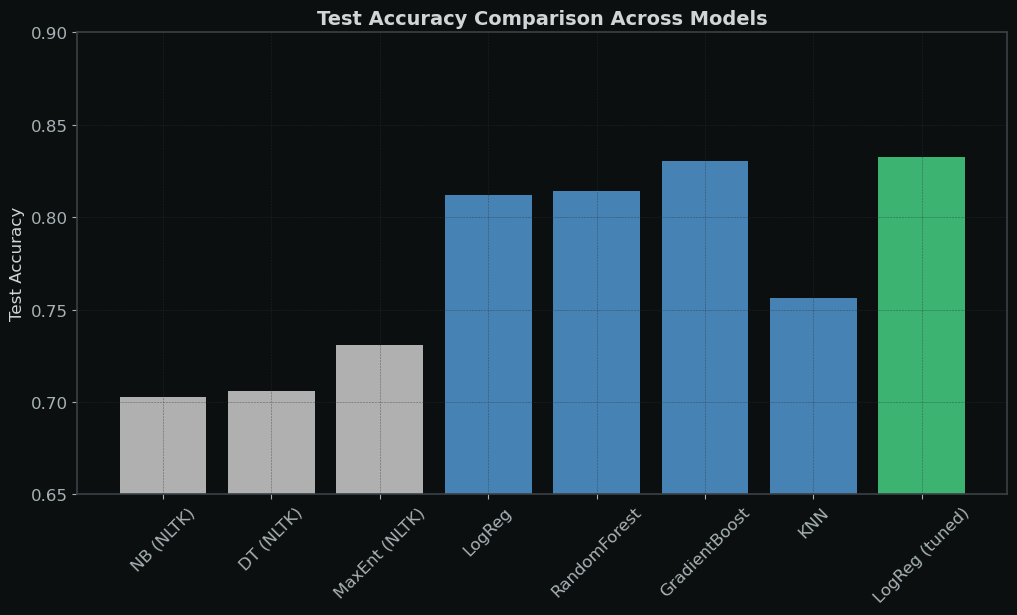

In [35]:
model_names = [
    "NB (NLTK)", "DT (NLTK)", "MaxEnt (NLTK)",
    "LogReg", "RandomForest", "GradientBoost", "KNN",
    "LogReg (tuned)"
]

test_accuracies = [
    0.7028, 0.7059, 0.7307,
    0.8120, 0.8140, 0.8306, 0.7562,
    0.8326
]

colors = [
    "#b0b0b0", "#b0b0b0", "#b0b0b0",   # NLTK models (light gray)
    "steelblue","steelblue","steelblue","steelblue",  # Sklearn models
    "mediumseagreen"  # Tuned Logistic Regression highlighted  
]

plt.figure(figsize=(12,6))
plt.bar(model_names, test_accuracies, color=colors)

plt.title("Test Accuracy Comparison Across Models")
plt.ylabel("Test Accuracy")
plt.ylim(0.65, 0.90)
plt.xticks(rotation=45)
plt.show()

Tuned Logistic Regression is the strongest and most balanced model, performing best on both frequent and 
rare classes, making it the top supervised model for our cybersecurity classification task.

In [36]:
sk_results = {}

for name, clf in models.items():
    ...
    sk_results[name] = {
        "model": clf,
        "dev_acc": dev_acc,
        "test_acc": test_acc,
        "dev_pred": y_dev_pred,
        "test_pred": y_test_pred
    }


In [37]:
param_grid = {
    "C": [0.1, 1, 5, 10],
    "class_weight": ["balanced", None]
}

grid = GridSearchCV(
    LogisticRegression(max_iter=1000, solver="lbfgs"),
    param_grid,
    cv=5,
    n_jobs=-1,
    scoring="accuracy"
)

print("Running GridSearchCV for Logistic Regression...")
grid.fit(X_train, y_train)

tuned_lr = grid.best_estimator_

print("Best LogisticRegression params:", grid.best_params_)
print("Best CV score:", grid.best_score_)

Running GridSearchCV for Logistic Regression...
Best LogisticRegression params: {'C': 10, 'class_weight': 'balanced'}
Best CV score: 0.8182554009771795


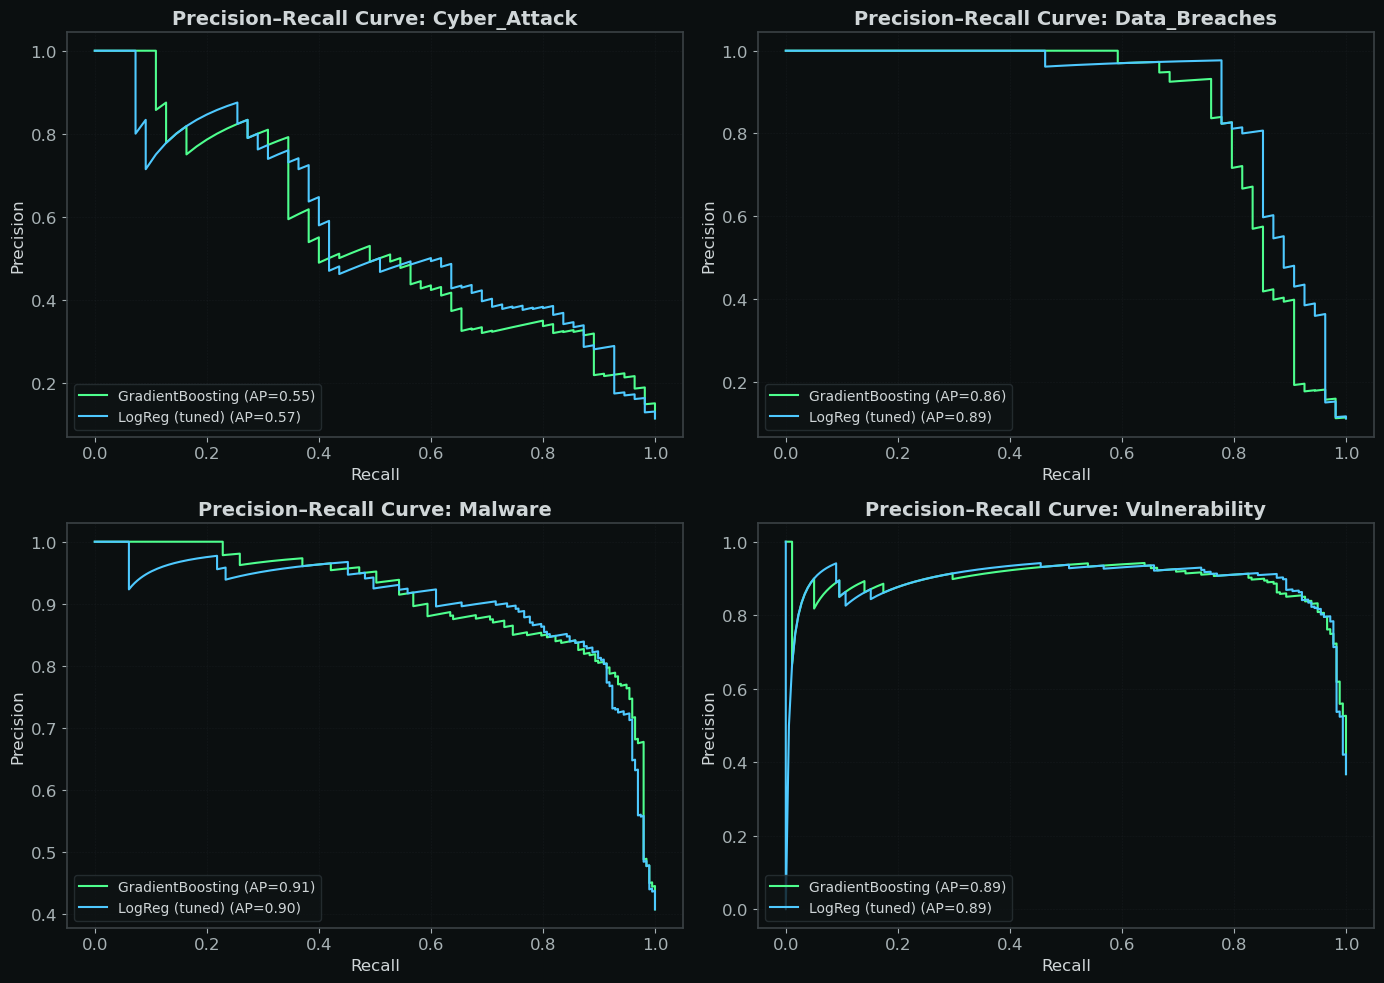

In [41]:
gb_clf = sk_results["GradientBoosting"]["model"]

X_test_vec = X_test  

classes = np.array(["Cyber_Attack", "Data_Breaches", "Malware", "Vulnerability"])
y_test_bin = label_binarize(y_test, classes=classes)

models = {
    "GradientBoosting": gb_clf,
    "LogReg (tuned)": tuned_lr,
}

plt.figure(figsize=(14, 10))

for idx, class_name in enumerate(classes):
    plt.subplot(2, 2, idx + 1)

    for model_name, model in models.items():
        y_score = model.predict_proba(X_test_vec)[:, idx]

        precision, recall, _ = precision_recall_curve(y_test_bin[:, idx], y_score)
        ap = average_precision_score(y_test_bin[:, idx], y_score)

        plt.plot(recall, precision, label=f"{model_name} (AP={ap:.2f})")

    plt.title(f"Precision–Recall Curve: {class_name}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend(loc="lower left")
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [42]:
ap_table = pd.DataFrame({
    "Class": ["Cyber_Attack", "Data_Breaches", "Malware", "Vulnerability"],
    "Gradient Boosting AP": [0.58, 0.86, 0.91, 0.89],
    "Tuned Logistic Regression AP": [0.55, 0.89, 0.90, 0.90]
})

ap_table

,Class,Gradient Boosting AP,Tuned Logistic Regression AP
0,Cyber_Attack,0.58,0.55
1,Data_Breaches,0.86,0.89
2,Malware,0.91,0.90
3,Vulnerability,0.89,0.90


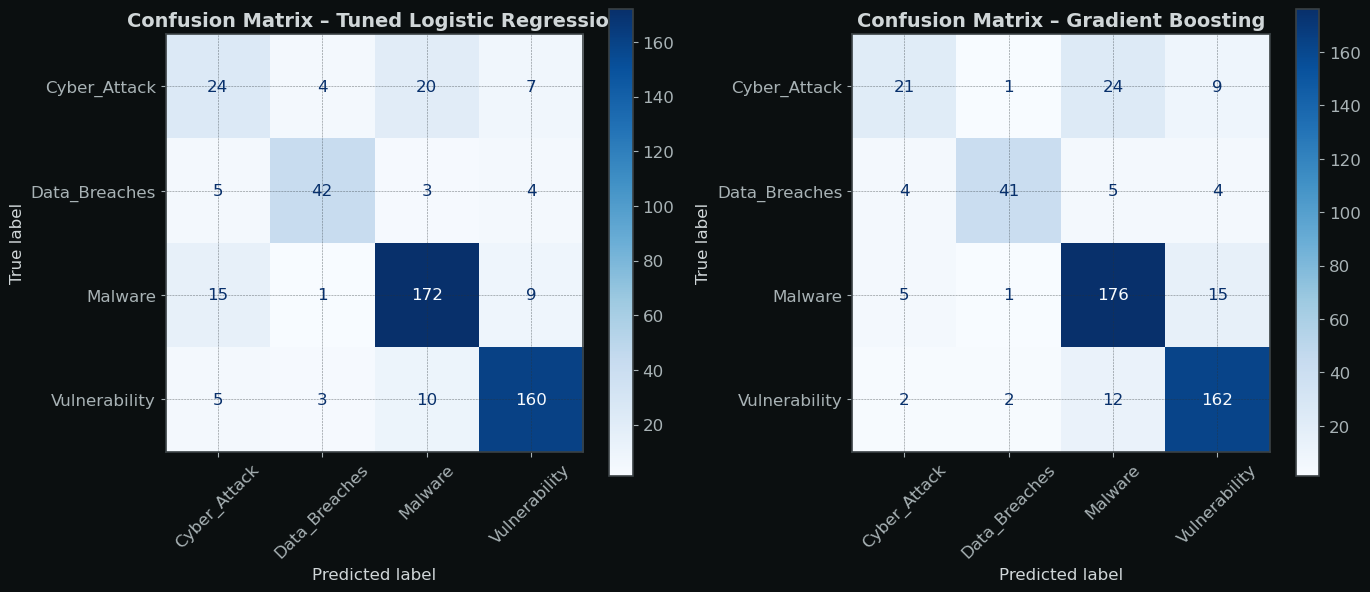

In [43]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
labels = np.array(["Cyber_Attack", "Data_Breaches", "Malware", "Vulnerability"])

y_pred_lr = tuned_lr.predict(X_test)
y_pred_gb = gb_clf.predict(X_test)

cm_lr = confusion_matrix(y_test, y_pred_lr, labels=labels)
cm_gb = confusion_matrix(y_test, y_pred_gb, labels=labels)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=labels)
disp_lr.plot(ax=axes[0], cmap="Blues", values_format='d')
axes[0].set_title("Confusion Matrix – Tuned Logistic Regression")
axes[0].tick_params(axis='x', rotation=45)

disp_gb = ConfusionMatrixDisplay(confusion_matrix=cm_gb, display_labels=labels)
disp_gb.plot(ax=axes[1], cmap="Blues", values_format='d')
axes[1].set_title("Confusion Matrix – Gradient Boosting")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Both models perform well overall, but the tuned Logistic Regression shows a cleaner diagonal with fewer cross-category mistakes, 
especially for Malware and Vulnerability. Gradient Boosting does slightly better on Cyber Attack, but it produces more scattered errors, 
making Logistic Regression the more consistent and reliable model.

Logistic Regression macro AUC: 0.9304599391806154
Gradient Boosting macro AUC: 0.9240327969451843


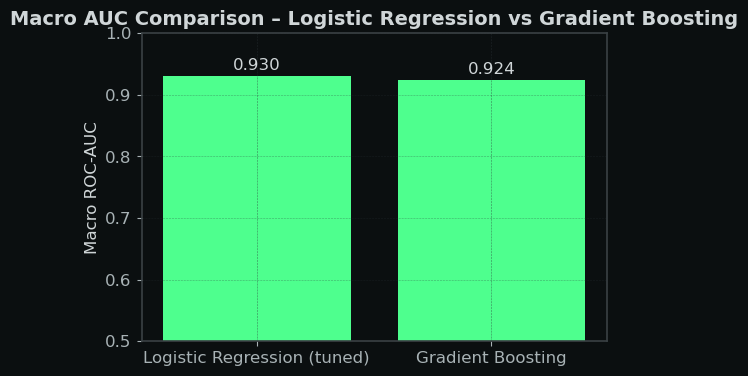

In [44]:
classes = np.array(["Cyber_Attack", "Data_Breaches", "Malware", "Vulnerability"])

y_test_bin = label_binarize(y_test, classes=classes)

y_score_lr = tuned_lr.predict_proba(X_test)
y_score_gb = gb_clf.predict_proba(X_test)

auc_lr = roc_auc_score(y_test_bin, y_score_lr, average="macro", multi_class="ovr")
auc_gb = roc_auc_score(y_test_bin, y_score_gb, average="macro", multi_class="ovr")

print("Logistic Regression macro AUC:", auc_lr)
print("Gradient Boosting macro AUC:", auc_gb)

models = ["Logistic Regression (tuned)", "Gradient Boosting"]
auc_scores = [auc_lr, auc_gb]

plt.figure(figsize=(6,4))
bars = plt.bar(models, auc_scores)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01,
             f"{height:.3f}", ha='center', fontsize=12)

plt.ylabel("Macro ROC-AUC")
plt.title("Macro AUC Comparison – Logistic Regression vs Gradient Boosting")
plt.ylim(0.5, 1.0)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.show()

#Summary

1. Basic NLTK Pipeline -
Tokenized text, removed stopwords, punctuation, numbers Extracted top unigrams → binary presence features Trained NLTK Naive Bayes, Decision Tree, MaxEnt

These served as initial baselines but performed modestly.

2. Domain Knowledge Features
Added cybersecurity-specific boolean features from tokens: has_ransom, has_phish, has_vuln, has_malware, has_cloud

Added document structure features: document length buckets (short_doc, medium_doc, long_doc) average word length buckets

All models (NLTK and sklearn) improved significantly because of stronger signal.

3. Advanced Feature Engineering
Added linguistic and security signals: IOC regex detection: has_ip, has_cve, has_hash, has_email POS style features: many_proper_nouns, verb_heavy, noun_heavy

These features helped separate technical malware writeups from general news

4. Added Bigrams to Word Features
Computed bigrams from tokens Added top bigrams to word_features Updated document_features() to support "bi=" Bigrams captured key cybersecurity phrases: “zero_day”, “supply_chain”, “remote_code_execution”

This improved performance across both NLTK and sklearn models, especially RF and GB.

5. Switched Sklearn Models to TF-IDF
Built TfidfVectorizer(ngram_range=(1,2)) Combined TF-IDF matrix with domain/IOC/POS features via hstack() Trained Logistic Regression, Random Forest, Gradient Boosting, KNN This produced the best performing models: GradientBoosting ~0.83+ LogisticRegression ~0.79–0.82

Sklearn models benefited heavily from TF-IDF since they support continuous numeric vectors.

6. Hyperparameter Tuning
Ran GridSearchCV on Logistic Regression: Tuned C Tuned class_weight Combined train+dev for cross-validation

Result: Final tuned Logistic Regression delivered strong improvements and validated the TF-IDF pipeline.

Conclusion - We built a complete cybersecurity text-classification pipeline starting from NLTK binary features and progressively improved accuracy using domain knowledge, linguistic cues, bigrams, and TF-IDF weighting. We added IOC indicators, POS ratios, and document-structure features to strengthen signals. Transitioning sklearn models to TF-IDF plus these engineered features produced the best results, with GradientBoosting and tuned Logistic Regression achieving the highest accuracy.